# Machine Learning in Exoplanet Exploration
### Machine Learning Engineer Nanodegree Capstone Project 

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

# Embed plots in the notebook
%matplotlib inline

# Add extension to reload modules automatically, in case they have been updated
%load_ext autoreload
%autoreload 2

---

### Kaggle dataset exploration

In [2]:
# Load training and test datasets
try:
    flux_train = pd.read_csv("Data\light_curve_Train.csv")
    print('Training dataset loaded: {} samples with {} features.'.format(*flux_train.shape))
except:
    print('Training dataset could not be loaded.')
    
try:
    flux_test = pd.read_csv("Data\light_curve_Test.csv")
    print('Test dataset loaded: {} samples with {} features.'.format(*flux_test.shape))
except:
    print('Test dataset could not be loaded.')

Training dataset loaded: 5087 samples with 3198 features.
Test dataset loaded: 570 samples with 3198 features.


In [3]:
# Seperate labels from other features
y_flux_train = flux_train['LABEL']
x_flux_train = flux_train.drop(['LABEL'],axis=1)

y_flux_test = flux_test['LABEL']
x_flux_test = flux_test.drop(['LABEL'],axis=1)

Confirmed exoplanet-stars in training set:  37
Confirmed exoplanet-stars in test set:  5


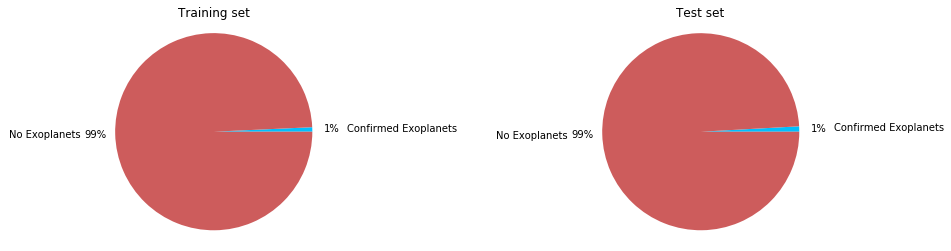

In [4]:
# Count number of exoplanet stars in the training and test datasets
n_exoplanets_train = y_flux_train[y_flux_train == 2].count()
n_exoplanets_test = y_flux_test[y_flux_test == 2].count()

print('Confirmed exoplanet-stars in training set: ', n_exoplanets_train)
print('Confirmed exoplanet-stars in test set: ', n_exoplanets_test)

# Plot pie chart for exoplanet vs non-exoplanet stars in the training and test datasets
fig = plt.figure(figsize=(16,4))
colors = ['deepskyblue','indianred']

plt.subplot(1,2,1)
plt.pie([n_exoplanets_train, y_flux_train.size-n_exoplanets_train], colors=colors, 
        labels=['Confirmed Exoplanets', 'No Exoplanets'], autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.35) 
plt.title('Training set')
plt.axis('equal')

plt.subplot(1,2,2)
plt.pie([n_exoplanets_test, y_flux_test.size-n_exoplanets_test], colors=colors, 
        labels=['Confirmed Exoplanets', 'No Exoplanets'], autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.35) 
plt.title('Test set')
plt.axis('equal')

plt.show()

In [5]:
x_flux_train.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


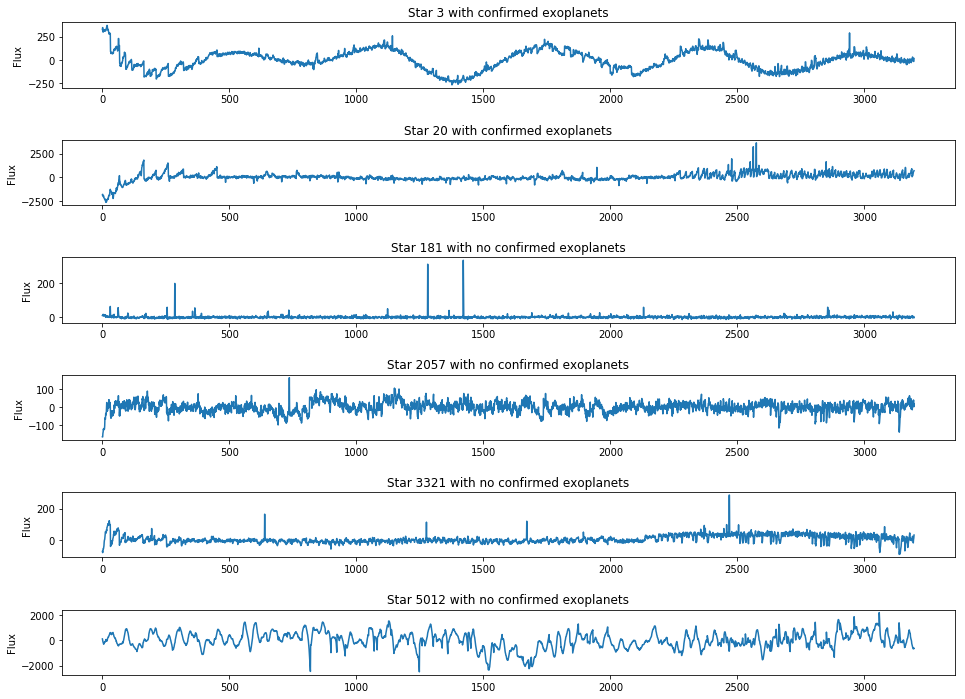

In [6]:
# Choose samples to visualise
samples = [3,20,181,2057,3321,5012]
n_samples = len(samples)


# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(samples)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(x_flux_train.iloc[samples[i]].values.tolist())
    plt.ylabel('Flux')
    title = 'Star {} with confirmed exoplanets'.format(samples[i]) if y_flux_train.iloc[samples[i]] == 2 else 'Star {} with no confirmed exoplanets'.format(samples[i])
    plt.title(title)

plt.show()

---

### Custom dataset creation using K2 data

In [2]:
# Load K2 candidates dataset
try:
    k2_cands = pd.read_csv("Data\k2candidates.csv",skiprows=range(149),header=1)
    print('K2 candidates dataset loaded: {} samples with {} features.'.format(*k2_cands.shape))
except:
    print('K2 candidates dataset could not be loaded.')

K2 candidates dataset loaded: 1737 samples with 147 features.


In [3]:
k2_cands.head()

,rowid,epic_name,tm_name,epic_candname,pl_name,k2c_refdisp,k2c_reflink,k2c_disp,k2c_note,k2_campaign,...,st_bmvjlim,st_jmh2,st_jmh2err,st_jmh2lim,st_hmk2,st_hmk2err,st_hmk2lim,st_jmk2,st_jmk2err,st_jmk2lim
0,1,EPIC 201092629,2MASS J12045739-0648180,EPIC 201092629.01,K2-241 b,CONFIRMED,<a refstr=LIVINGSTON_ET_AL__2018 href=http://a...,CONFIRMED,NaN,10,...,0.0,0.454,0.032,0.0,0.055,0.031,0.0,0.509,0.033,0.0
1,2,EPIC 201102594,2MASS J11592060-0631042,EPIC 201102594.01,K2-242 b,CONFIRMED,<a refstr=LIVINGSTON_ET_AL__2018 href=http://a...,CONFIRMED,NaN,10,...,0.0,0.606,0.032,0.0,0.238,0.034,0.0,0.844,0.033,0.0
2,3,EPIC 201110617,2MASS J12104805-0617391,EPIC 201110617.01,K2-156 b,CONFIRMED,<a refstr=MAYO_ET_AL__2018 href=http://adsabs....,CONFIRMED,NaN,10,...,0.0,0.567,0.039,0.0,0.181,0.034,0.0,0.748,0.038,0.0
3,4,EPIC 201110617,2MASS J12104805-0617391,EPIC 201110617.01,K2-156 b,CONFIRMED,<a refstr=LIVINGSTON_ET_AL__2018 href=http://a...,CONFIRMED,NaN,10,...,0.0,0.567,0.039,0.0,0.181,0.034,0.0,0.748,0.038,0.0
4,5,EPIC 201111557,2MASS J12152316-0616056,EPIC 201111557.01,NaN,CANDIDATE,<a refstr=MAYO_ET_AL__2018 href=http://adsabs....,CANDIDATE,NaN,10,...,0.0,0.482,0.033,0.0,0.171,0.030,0.0,0.653,0.030,0.0


In [4]:
# Extract candidate star name and campaign number and store in new dataframe
k2_cand_names = k2_cands[['epic_name','k2_campaign']]
k2_cand_names.head()

,epic_name,k2_campaign
0,EPIC 201092629,10
1,EPIC 201102594,10
2,EPIC 201110617,10
3,EPIC 201110617,10
4,EPIC 201111557,10


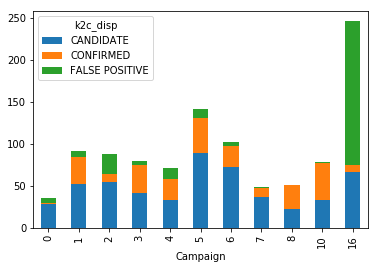

In [5]:
# Count candidates by campaign and disposition (Confirmed, Candidate or False positive)
candidates_count = k2_cands.groupby(['k2_campaign','k2c_disp'])['epic_name'].nunique()
candidates_count = pd.DataFrame(candidates_count)

# Re-index count dataframe including all combinations of k2_campaign and k2c_disp
new_index = pd.MultiIndex.from_product(candidates_count.index.levels,names=candidates_count.index.names)
candidates_count = candidates_count.reindex(new_index, fill_value=0)
candidates_count.reset_index(level=0, inplace=True)
candidates_count.reset_index(level=0, inplace=True)

# Plot stacked bar chart to visualise objects of interest by campaign
piv = candidates_count.pivot(values='epic_name', columns='k2c_disp', index='k2_campaign')
piv.plot.bar(stacked=True)
plt.xlabel('Campaign')

plt.show()

In [ ]:
# Compile all kepler fits files for a chosen campaign into a single flux time-series dataset
from flux_load import flux_compiler
campaign = 10
flux_compiler(campaign, k2_cand_names)

In [6]:
# Load flux datasets for each chosen campaign
try:
    flux_1 = pd.read_csv("Data\c1_lightcurves.csv")
    flux_3 = pd.read_csv("Data\c3_lightcurves.csv")
    flux_5 = pd.read_csv("Data\c5_lightcurves.csv")
    #flux_10 = pd.read_csv("Data\c10_lightcurves.csv")
    labels_1 = pd.read_csv("Data\c1_labels.csv")
    labels_3 = pd.read_csv("Data\c3_labels.csv")
    labels_5 = pd.read_csv("Data\c5_labels.csv")
    #labels_10 = pd.read_csv("Data\c10_labels.csv")

    
    flux_1.columns.values[0] = "epic_name"
    flux_3.columns.values[0] = "epic_name"
    flux_5.columns.values[0] = "epic_name"
    #flux_10.columns.values[0] = "epic_name"
    labels_1.columns.values[0] = "epic_name"
    labels_3.columns.values[0] = "epic_name"
    labels_5.columns.values[0] = "epic_name"
    #labels_10.columns.values[0] = "epic_name"

    
    print('Datasets loaded successfully')
except:
    print('Datasets could not be loaded.')

Datasets loaded successfully


In [7]:
# Calculate length of time-series for each candidate ('label' = 1) in each campaign
flux_len_1 = flux_1.loc[labels_1.index[labels_1['label']==1]].count(axis=1)
flux_len_3 = flux_3.loc[labels_3.index[labels_3['label']==1]].count(axis=1)
flux_len_5 = flux_5.loc[labels_5.index[labels_5['label']==1]].count(axis=1)
#flux_len_10 = flux_10.loc[labels_10.index[labels_10['label']==1]].count(axis=1)

In [8]:
# Time-series length statistics for each campaign
print('Campaign 1 time-series lengths:')
print('Min = {:d}'.format(flux_len_1.min()))
print('Max = {:d}'.format(flux_len_1.max()))
print('Mean = {:.0f}'.format(flux_len_1.mean()))

print('\nCampaign 3 time-series lengths:')
print('Min = {:d}'.format(flux_len_3.min()))
print('Max = {:d}'.format(flux_len_3.max()))
print('Mean = {:.0f}'.format(flux_len_3.mean()))

print('\nCampaign 5 time-series lengths:')
print('Min = {:d}'.format(flux_len_5.min()))
print('Max = {:d}'.format(flux_len_5.max()))
print('Mean = {:.0f}'.format(flux_len_5.mean()))

#print('\nCampaign 10 time-series lengths:')
#print('Min = {:d}'.format(flux_len_10.min()))
#print('Max = {:d}'.format(flux_len_10.max()))
#print('Mean = {:.0f}'.format(flux_len_10.mean()))

Campaign 1 time-series lengths:
Min = 3286
Max = 3556
Mean = 3530

Campaign 3 time-series lengths:
Min = 2984
Max = 3190
Mean = 3163

Campaign 5 time-series lengths:
Min = 3348
Max = 3457
Mean = 3437


In [9]:
# Combine the flux series from each of the chosen campaigns
flux_raw = pd.concat([flux_1,flux_3,flux_5], ignore_index=True, sort=False)
labels = pd.concat([labels_1,labels_3,labels_5], ignore_index=True, sort=False)
print('Combined flux dataset: size {:d} x {:d}'.format(*flux_raw.shape))

Combined flux dataset: size 64254 x 3556


In [10]:
# Isolate data for all stars with exoplanet candidates in the combined dataset
exoplanet_cands = flux_raw.loc[labels.index[labels['label']==1]]

# Calculate length of time-series for each candidate ('label' = 1) in the combined dataset
cands_flux_len = exoplanet_cands.count(axis=1)-1

# Number of exoplanet candidates in the combined dataset
print('The dataset contains {:d} exoplanet candidates.'.format(len(exoplanet_cands)))

# Time-series length statistics
print('\nCombined dataset time-series lenghts:')
print('Min = {:d}'.format(cands_flux_len.min()))
print('Max = {:d}'.format(cands_flux_len.max()))
print('Mean = {:.0f}'.format(cands_flux_len.mean()))

The dataset contains 303 exoplanet candidates.

Combined dataset time-series lenghts:
Min = 2983
Max = 3555
Mean = 3392


In [11]:
# Set minimum time-series length required to keep a given sample in the dataset 
min_flux_len = int(flux_len_3.mean())+1

# Truncate flux dataset by only keeping the first min_flux_len columns
truncated_flux_raw = flux_raw[flux_raw.columns[:min_flux_len]]

In [12]:
# Find rows with missing values (i.e. samples with less than min_flux_len points in their flux time-series)
na_rows = pd.isnull(truncated_flux_raw).any(1).nonzero()[0]

# Remove rows with missing values from the flux and label sets
truncated_flux_data = truncated_flux_raw.drop(truncated_flux_raw.index[na_rows])
truncated_labels = labels.drop(labels.index[na_rows])

In [13]:
# Count number of exoplanet candidates in the truncated dataset
truncated_exoplanet_cands = truncated_flux_data.loc[truncated_labels.index[truncated_labels['label']==1]]
print('The truncated dataset has size {:d} x {:d} and contains {:d} exoplanet candidates.'.format(*truncated_flux_data.shape,len(truncated_exoplanet_cands)))

The truncated dataset has size 60645 x 3163 and contains 279 exoplanet candidates.


In [14]:
import random

# Set random seed to ensure repeatability of random sample selection
random.seed(42)

# Set number of non-exoplanet stars to be included in the dataset
n_non_exoplanet = 4000-len(truncated_exoplanet_cands)

# Randomly select 'n_non_exoplanet' non-exoplanet stars to include in the dataset 
non_exoplanets_sample = random.sample(list(truncated_labels.index[truncated_labels['label']==0]),n_non_exoplanet)

# Indices of exoplanet-candidate stars and selected non-exoplanet stars
full_sample = list(truncated_labels.index[truncated_labels['label']==1]) + non_exoplanets_sample

# Extract the specified sample from the full dataset  
flux_sample = truncated_flux_data.loc[full_sample,:]
labels_sample = truncated_labels.loc[full_sample,:]

# Save flux and label sample datasets
flux_sample.to_csv("Data\\flux_sample.csv")
labels_sample.to_csv("Data\\labels_sample.csv")

---

### Dataset exploration and pre-processing

In [2]:
# Load custom dataset
try:
    flux = pd.read_csv("Data/flux_sample.csv", index_col=1)
    flux.drop('Unnamed: 0', axis=1, inplace=True)
    labels = pd.read_csv("Data/labels_sample.csv",index_col=1)
    labels.drop('Unnamed: 0', axis=1, inplace=True)
    print('Dataset loaded: {} samples with {} features.'.format(*flux.shape))
except:
    print('Training dataset could not be loaded.')

Dataset loaded: 4000 samples with 3162 features.


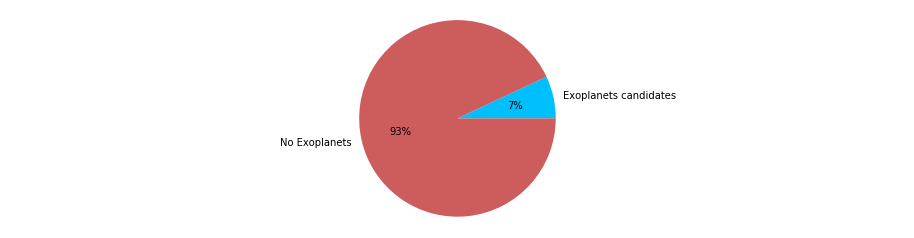

In [3]:
# Count number of exoplanet candidates in the dataset
n_candidates = labels[labels['label']==1].count()['label']

# Plot pie chart for exoplanet-candidate vs non-exoplanet stars in the training and test datasets
fig = plt.figure(figsize=(16,4))
colors = ['deepskyblue','indianred']

plt.pie([n_candidates, flux.shape[0]-n_candidates], colors=colors, 
        labels=['Exoplanets candidates', 'No Exoplanets'], autopct='%1.0f%%') 
plt.axis('equal')
plt.show()

In [4]:
flux.head()

,0,1,2,3,4,5,6,7,8,9,...,3152,3153,3154,3155,3156,3157,3158,3159,3160,3161
epic_name,,,,,,,,,,,,,,,,,,,,,
EPIC 201126503,671.556213,684.749084,675.719666,690.858154,691.162415,694.080627,689.405396,695.643372,708.252686,693.001953,...,690.592529,682.658630,696.794556,706.005615,701.794312,705.358887,697.711731,705.820618,696.314453,694.699280
EPIC 201155177,16629.332031,16641.957031,16602.951172,17132.261719,17137.101562,17124.759766,17143.548828,17124.330078,17136.015625,17140.457031,...,17121.007812,17114.365234,17110.667969,17117.734375,17141.994141,17120.945312,17110.550781,17129.117188,17114.902344,17121.421875
EPIC 201176672,32872.589844,32855.265625,32908.257812,32760.240234,32744.470703,32762.095703,32766.125000,32743.871094,32752.191406,32760.648438,...,32757.542969,32714.050781,32726.222656,32655.695312,32670.791016,32671.843750,32708.904297,32734.306641,32729.978516,32753.453125
EPIC 201182911,8287.248047,8292.537109,8259.041992,8246.769531,8238.206055,8234.342773,8228.845703,8226.708984,8231.898438,8221.932617,...,8183.235352,8185.875000,8218.062500,8240.030273,8245.794922,8254.473633,8261.513672,8298.529297,8291.562500,8298.814453
EPIC 201197348,11784.993164,11810.388672,11807.846680,11473.319336,11481.638672,11472.532227,11466.393555,11489.285156,11471.574219,11475.936523,...,11511.348633,11507.869141,11504.044922,11525.999023,11544.324219,11528.520508,11530.051758,11521.109375,11508.415039,11509.752930


In [5]:
# Normalise or standardise flux data
def normalise(x): 
    x_norm = (x - min(x)) / (max(x) - min(x)) 
    return x_norm

def standardise(x):
    x_std = (x-np.mean(x)) / np.std(x)
    return x_std

flux_norm = flux.apply(lambda row : normalise(row), axis = 1)
flux_std = flux.apply(lambda row : standardise(row), axis = 1)

In [6]:
flux_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,3152,3153,3154,3155,3156,3157,3158,3159,3160,3161
epic_name,,,,,,,,,,,,,,,,,,,,,
EPIC 201126503,0.050541,0.072130,0.057354,0.082127,0.082625,0.087400,0.079750,0.089958,0.110592,0.085635,...,0.081692,0.068709,0.091842,0.106915,0.100023,0.105857,0.093342,0.106612,0.091056,0.088413
EPIC 201155177,0.040426,0.059773,0.000000,0.811124,0.818540,0.799628,0.828420,0.798969,0.816876,0.823682,...,0.793878,0.783699,0.778033,0.788862,0.826038,0.793782,0.777854,0.806305,0.784522,0.794513
EPIC 201176672,0.560614,0.551761,0.578839,0.503207,0.495149,0.504155,0.506213,0.494842,0.499094,0.503415,...,0.501828,0.479605,0.485825,0.449787,0.457501,0.458039,0.476976,0.489955,0.487744,0.499739
EPIC 201182911,0.947444,0.948960,0.939359,0.935841,0.933387,0.932279,0.930704,0.930091,0.931579,0.928722,...,0.917630,0.918387,0.927613,0.933910,0.935562,0.938049,0.940067,0.950677,0.948680,0.950759
EPIC 201197348,0.698963,0.742137,0.737816,0.169096,0.183239,0.167757,0.157321,0.196239,0.166129,0.173545,...,0.233748,0.227833,0.221331,0.258655,0.289809,0.262941,0.265545,0.250342,0.228761,0.231035


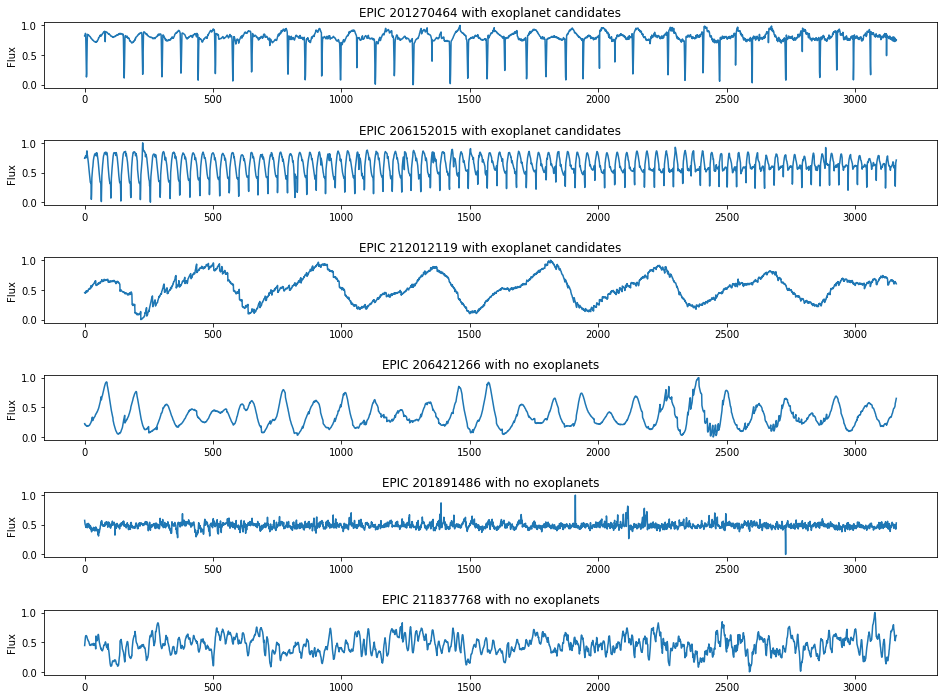

In [7]:
# Choose samples to visualise
samples = [15,120,260,693,2057,3321]
n_samples = len(samples)

# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(samples)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(flux_norm.iloc[samples[i]].values.tolist())
    plt.ylabel('Flux')
    title = '{} with exoplanet candidates'.format(labels.iloc[samples[i]].name) if labels.iloc[samples[i]].label == 1 else '{} with no exoplanets'.format(labels.iloc[samples[i]].name)
    plt.title(title)

plt.show()

In [8]:
from scipy.signal import savgol_filter, medfilt

# Set Savitzky–Golay filter parameters
window = 15
poly = 3

# Apply Savitzky–Golay and median filter to the unnormalised flux data
flux_sg = flux.apply(lambda row : savgol_filter(row, window, poly), axis = 1)
flux_med = flux.apply(lambda row : medfilt(row), axis = 1)

# Apply Savitzky–Golay and median filter to the normalised flux data
flux_norm_sg = flux_norm.apply(lambda row : savgol_filter(row, window, poly), axis = 1)
flux_norm_med = flux_norm.apply(lambda row : medfilt(row), axis = 1)

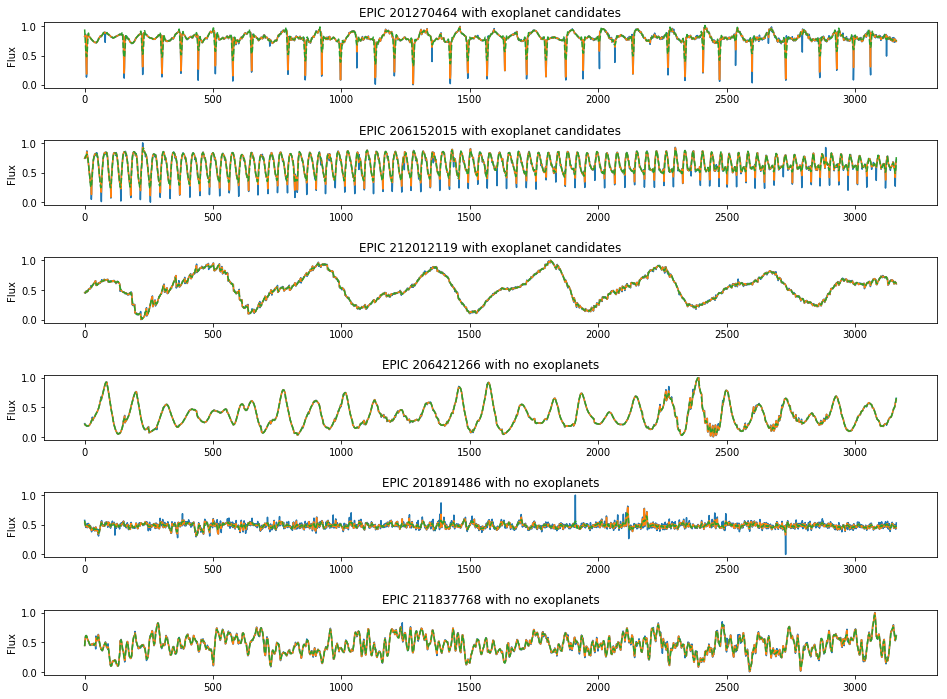

In [9]:
# Choose samples to visualise
samples = [15,120,260,693,2057,3321]
n_samples = len(samples)

# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(samples)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(flux_norm.iloc[samples[i]].values.tolist())
    plt.plot(flux_norm_med[samples[i]])
    plt.plot(flux_norm_sg[samples[i]],'--')
    plt.ylabel('Flux')
    title = '{} with exoplanet candidates'.format(labels.iloc[samples[i]].name) if labels.iloc[samples[i]].label == 1 else '{} with no exoplanets'.format(labels.iloc[samples[i]].name)
    plt.title(title)

plt.show()

In [10]:
# Define filter that finds and removes upper outliers, since we are only interested in dips of flux

def upper_outliers_filter(x, pct_filter, window_size):
    #x: array
    #pct_filter: percentage of points with highest values to be filtered 
    #window_size: size of filter window - one-sided, i.e. total size will be 
    #             2*window_size+1 (including central point under question)
    
    # make copy of array to be filtered
    x_filtered = list(x)
    
    length = len(x) #length of array
    n_filter = int(pct_filter*len(x))
    top = np.argsort(x)[::-1][:n_filter] #indices of top n_filter points to be filtered

    # for each point calculate mean of its surrounding points within the window size
    for point in top:
        if point-window_size >= 0 and point+window_size<=length:
            mean_surrounding = (np.sum(x[point-(window_size+1):point-1])+np.sum(x[point+1:point+(window_size+1)]))/(2*window_size)
        elif point-window_size<0 and point+2*window_size<=length:
            mean_surrounding = np.sum(x[point+1:point+2*window_size+1])/(2*window_size)
        elif point+window_size>length and point-2*window_size>=0:
            mean_surrounding = np.sum(x[point-(2*window_size+1):point-1])/(2*window_size)
        else:
            mean_surrounding = np.nan

        #if point's value is higher than the mean of the surrounding points reduce its value to mean_surrounding
        if np.isnan(mean_surrounding)==False and x[point]>mean_surrounding:
            x_filtered[point]=mean_surrounding
    
    return x_filtered

In [11]:
# Apply upper outlier filter to median filtered flux data
flux_med_up = flux_med.apply(lambda row : upper_outliers_filter(row, 0.1, 5))

# Apply upper outlier filter to median filtered normalised flux data
flux_norm_med_up = flux_norm_med.apply(lambda row : upper_outliers_filter(row, 0.1, 5))

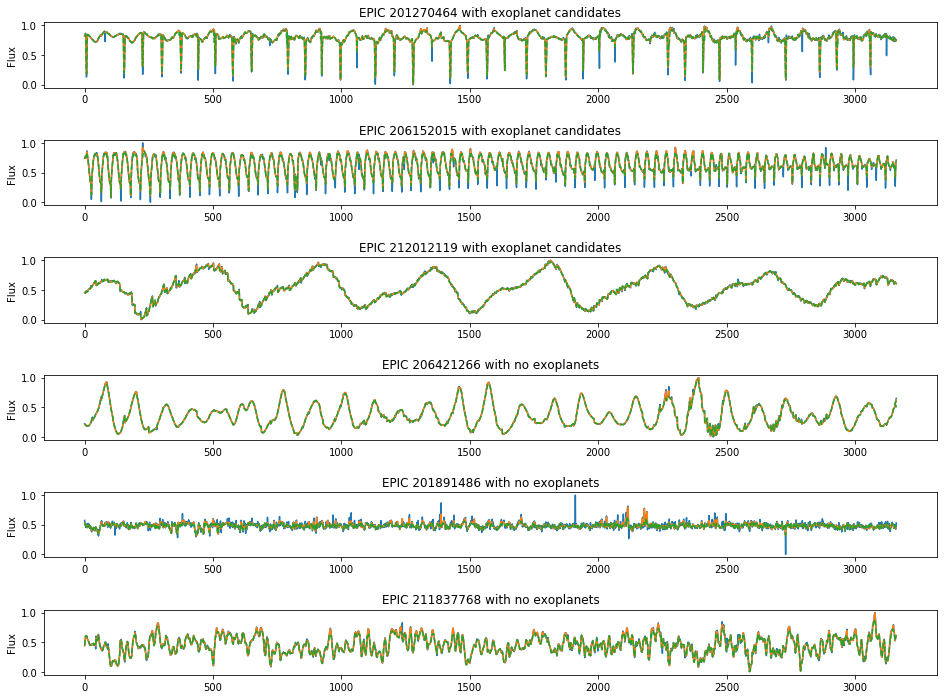

In [12]:
# Choose samples to visualise
samples = [15,120,260,693,2057,3321]
n_samples = len(samples)

# Plot time-series data for the selected samples 
fig = plt.figure(figsize=(16,len(samples)*2))
plt.subplots_adjust(hspace=0.8)

for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(flux_norm.iloc[samples[i]].values.tolist())
    plt.plot(flux_norm_med[samples[i]])
    plt.plot(flux_norm_med_up[samples[i]],'--')
    plt.ylabel('Flux')
    title = '{} with exoplanet candidates'.format(labels.iloc[samples[i]].name) if labels.iloc[samples[i]].label == 1 else '{} with no exoplanets'.format(labels.iloc[samples[i]].name)
    plt.title(title)

plt.show()

#### Feature Extraction - tsfresh

In [10]:
# Reshape normalised flux dataframe to the format required by the feature extraction package tsfresh 
flux_norm_stacked = flux_norm.stack().reset_index().rename(columns={'level_1':'time', 0:'value'})
flux_norm_stacked.head()

,epic_name,time,value
0,EPIC 201126503,0,-0.021168
1,EPIC 201126503,1,0.000421
2,EPIC 201126503,2,-0.014355
3,EPIC 201126503,3,0.010418
4,EPIC 201126503,4,0.010916


In [ ]:
# Extract EfficientFCParameters using tsfresh package

from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters

# Run tsfresh.extract_features on multiple batches of the dataset
series_len = flux_norm.shape[1] # time-series length
n_batch = 5 # batch size
i_max = int(flux_norm_stacked['epic_name'].nunique()/n_batch) # total number of batches
       
flux_features = pd.DataFrame() # empty dataframe to store extracted features

# Run tsfresh.extract_features in a loop
for i in range(0,i_max):
    flux_s = flux_norm_stacked[i*(n_batch)*(series_len):((i+1)*n_batch)*(series_len)]
    extracted_features = extract_features(flux_s, column_id='epic_name', column_sort='time',default_fc_parameters=EfficientFCParameters())
    flux_features = flux_features.append(extracted_features)

flux_features.to_csv("Data\\flux_features.csv")

In [ ]:
# Extract MinimalFCParameters using tsfresh package
from tsfresh.feature_extraction import MinimalFCParameters

# Run tsfresh.extract_features on multiple batches of the dataset
series_len = flux_norm.shape[1] # time-series length
n_batch = 5 # batch size
i_max = int(flux_norm_stacked['epic_name'].nunique()/n_batch) # total number of batches
       
flux_features = pd.DataFrame() # empty dataframe to store extracted features

# Run tsfresh.extract_features in a loop
for i in range(0,i_max):
    flux_s = flux_norm_stacked[i*(n_batch)*(series_len):((i+1)*n_batch)*(series_len)]
    extracted_features = extract_features(flux_s, column_id='epic_name', column_sort='time',default_fc_parameters=MinimalFCParameters())
    flux_features = flux_features.append(extracted_features)

flux_features.to_csv("Data\\flux_min_features.csv")

In [11]:
# Load extracted features
try:
    flux_features = pd.read_csv("Data\\flux_features.csv", index_col=0)
    print('Extracted features loaded: {} samples with {} features.'.format(*flux_features.shape))
except:
    print('Extracted features could not be loaded.')

Extracted features loaded: 4000 samples with 788 features.


In [12]:
flux_features.head()

,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
EPIC 201126503,2.248515,47.430377,0.099014,0.083611,0.002189,0.014459,0.139936,0.000087,0.000035,0.022071,...,1.0,1.0,-0.000001,0.000006,0.000008,0.0,0.0,0.0,0.000711,0.0
EPIC 201155177,7.531924,72.580588,0.446496,0.436484,0.001286,0.044260,-0.040445,-0.000016,0.000022,0.067008,...,1.0,1.0,0.000117,-0.000022,0.000004,0.0,0.0,0.0,0.002382,0.0
EPIC 201176672,4.301871,51.766755,0.130154,0.040076,0.036128,0.030348,0.061379,0.000024,0.000022,0.068834,...,1.0,1.0,-0.000004,-0.000009,-0.000011,0.0,0.0,0.0,0.001360,0.0
EPIC 201182911,71.443673,154.608957,-0.014863,-0.036545,0.010942,0.053359,0.110186,0.000027,0.000013,0.075091,...,1.0,1.0,-0.000310,-0.000191,0.000133,0.0,0.0,0.0,0.022594,0.0
EPIC 201197348,7.706753,86.179396,0.226412,0.197876,0.006370,0.047315,0.057005,0.000040,0.000039,0.089718,...,1.0,1.0,-0.000018,-0.000018,-0.000018,0.0,0.0,0.0,0.002437,0.0


#### Feature Extraction - FATS

##### FATS feature extraction on raw flux data

In [10]:
import FATS

# Obtain list of features that can be calculated using only the flux magnitude of a star's light-curve
feature_list = FATS.FeatureSpace(Data=['magnitude'])

# Empty array to save extracted features
features = []

# Calculate time-series features for each normalised flux using FATS 
for i in range(0,len(flux)):
    features_=feature_list.calculateFeature(np.array([flux.iloc[i].get_values()]))
    features.append(features_.result(method='array'))
    
# Save to dataframe
features = pd.DataFrame(features,index=flux.index.values, columns=features_.result(method='features'))

features.to_csv("Data\\flux_features_FATS.csv")

In [13]:
# Load extracted features
try:
    flux_features = pd.read_csv("Data\\flux_features_FATS.csv", index_col=0)
    print('Extracted features loaded: {} samples with {} features.'.format(*flux_features.shape))
except:
    print('Extracted features could not be loaded.')

Extracted features loaded: 4000 samples with 22 features.


In [14]:
flux_features.head()

,Amplitude,AndersonDarling,Autocor_length,Con,FluxPercentileRatioMid20,FluxPercentileRatioMid35,FluxPercentileRatioMid50,FluxPercentileRatioMid65,FluxPercentileRatioMid80,Gskew,...,MedianAbsDev,MedianBRP,PairSlopeTrend,PercentAmplitude,PercentDifferenceFluxPercentile,Q31,Rcs,Skew,SmallKurtosis,Std
EPIC 201126503,22.932434,1.0,2.0,0.001582,0.158808,0.273418,0.404381,0.559958,0.767591,-0.912231,...,7.816986,0.998102,0.033333,0.829617,0.056403,15.587280,0.137022,14.227059,474.167088,16.295498
EPIC 201155177,52.321289,1.0,112.0,0.004430,0.172994,0.313165,0.453045,0.600103,0.806547,-12.294922,...,19.621094,0.979760,-0.033333,0.030827,0.005099,39.570801,0.185107,-3.855921,59.018590,31.848973
EPIC 201176672,90.452148,1.0,7.0,0.009810,0.160525,0.279137,0.393882,0.553403,0.777500,4.132812,...,28.348633,0.991145,0.100000,0.030116,0.004332,55.885742,0.093000,-5.395128,85.819378,72.186200
EPIC 201182911,1256.676025,1.0,2.0,0.010443,0.060028,0.107357,0.154406,0.188290,0.229749,-2497.240723,...,92.891357,0.929791,0.300000,0.395677,0.149348,190.189697,0.025078,-4.073255,16.637163,524.418979
EPIC 201197348,50.822266,1.0,5.0,0.011392,0.150207,0.261663,0.380392,0.541172,0.751047,-15.131836,...,15.239258,0.967426,-0.033333,0.038475,0.006984,30.595947,0.152298,1.508301,27.250484,29.039416


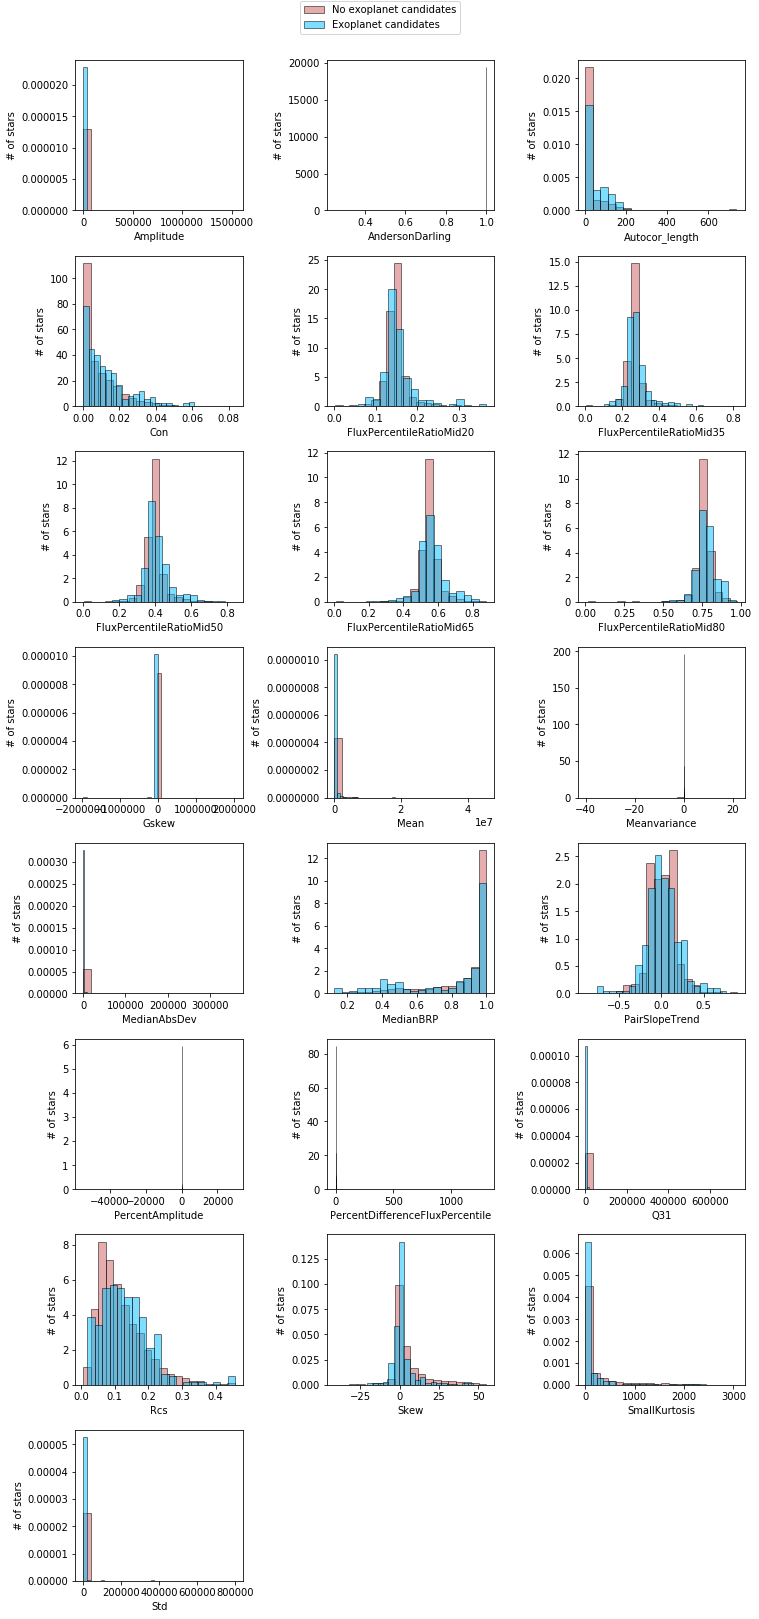

In [15]:
n_exoplanet = labels.label.sum()

fig = plt.figure(figsize=(12,25))
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.3)

for i,feature in enumerate(flux_features.columns.values):
    ax = fig.add_subplot(8,3,i+1)
    
    pos_feature = flux_features[feature].iloc[:n_exoplanet].values
    neg_feature = flux_features[feature].iloc[n_exoplanet:].values
    
    ax.hist(neg_feature,alpha=0.5,bins=20,color='indianred',edgecolor='black',density=True,label='No exoplanet candidates')
    ax.hist(pos_feature,alpha=0.5,bins=20,color='deepskyblue',edgecolor='black',density=True,label='Exoplanet candidates')

    ax.set_xlabel(feature)
    ax.set_ylabel('# of stars')  

fig.legend(labels=['No exoplanet candidates','Exoplanet candidates'],loc="upper center",borderaxespad=0.1)
plt.subplots_adjust(top=0.97)
plt.show()
    

##### FATS feature extraction on normalised or standardised flux data

In [32]:
import FATS

# Obtain list of features that can be calculated using only the flux magnitude of a star's light-curve
feature_list = FATS.FeatureSpace(Data=['magnitude'])

# Empty array to save extracted features
features = []

# Calculate time-series features for each normalised flux using FATS 
for i in range(0,len(flux_std)):
    features_=feature_list.calculateFeature(np.array([flux_std.iloc[i].get_values()]))
    features.append(features_.result(method='array'))
    
# Save to dataframe
features = pd.DataFrame(features,index=flux.index.values, columns=features_.result(method='features'))

features.to_csv("Data\\flux_std_FATS.csv")

C:\Users\Alex\Anaconda3\envs\ipykernel_py2\lib\site-packages\fats-1.3.6-py2.7.egg\FATS\FeatureFunctionLib.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  return np.std(magnitude) / np.mean(magnitude)


In [16]:
# Load features extracted from median filtered flux data
try:
    flux_norm_features = pd.read_csv("Data\\flux_norm_FATS.csv", index_col=0)
    print('Extracted norm_features loaded: {} samples with {} features.'.format(*flux_norm_features.shape))
except:
    print('Extracted norm_features could not be loaded.')
    
# Load features extracted from Savitzky–Golay filtered flux data 
try:
    flux_std_features = pd.read_csv("Data\\flux_std_FATS.csv", index_col=0)
    print('Extracted std_features loaded: {} samples with {} features.'.format(*flux_std_features.shape))
except:
    print('Extracted std_features could not be loaded.')    

Extracted norm_features loaded: 4000 samples with 22 features.
Extracted std_features loaded: 4000 samples with 22 features.


##### FATS feature extraction on flux data after median or Savitzky–Golay filter

In [ ]:
import FATS

# Obtain list of features that can be calculated using only the flux magnitude of a star's light-curve
feature_list = FATS.FeatureSpace(Data=['magnitude'])

# Empty array to save extracted features
features = []

# Calculate time-series features for each normalised flux using FATS 
for i in range(0,len(flux_med_up)):
    features_=feature_list.calculateFeature(np.array([flux_med_up[i]]))
    features.append(features_.result(method='array'))
    
# Save to dataframe
features = pd.DataFrame(features,index=flux.index.values, columns=features_.result(method='features'))

features.to_csv("Data\\flux_med_up_features_FATS.csv")

In [17]:
# Load features extracted from median filtered flux data
try:
    flux_med_features = pd.read_csv("Data\\flux_med_features_FATS.csv", index_col=0)
    print('Extracted med_features loaded: {} samples with {} features.'.format(*flux_med_features.shape))
except:
    print('Extracted med_features could not be loaded.')

# Load features extracted from median filtered normalised flux data
try:
    flux_norm_med_features = pd.read_csv("Data\\flux_norm_med_features_FATS.csv", index_col=0)
    print('Extracted norm_med_features loaded: {} samples with {} features.'.format(*flux_norm_med_features.shape))
except:
    print('Extracted norm_med_features could not be loaded.')

# Load features extracted from Savitzky–Golay filtered flux data 
try:
    flux_sg_features = pd.read_csv("Data\\flux_sg_features_FATS.csv", index_col=0)
    print('Extracted sg_features loaded: {} samples with {} features.'.format(*flux_sg_features.shape))
except:
    print('Extracted sg_features could not be loaded.')
    
# Load features extracted from median and upper-outlier filtered flux data
try:
    flux_med_up_features = pd.read_csv("Data\\flux_med_up_features_FATS.csv", index_col=0)
    print('Extracted med_up_features loaded: {} samples with {} features.'.format(*flux_med_up_features.shape))
except:
    print('Extracted med_up_features could not be loaded.')

Extracted med_features loaded: 4000 samples with 22 features.
Extracted norm_med_features loaded: 4000 samples with 22 features.
Extracted sg_features loaded: 4000 samples with 22 features.
Extracted med_up_features loaded: 4000 samples with 22 features.


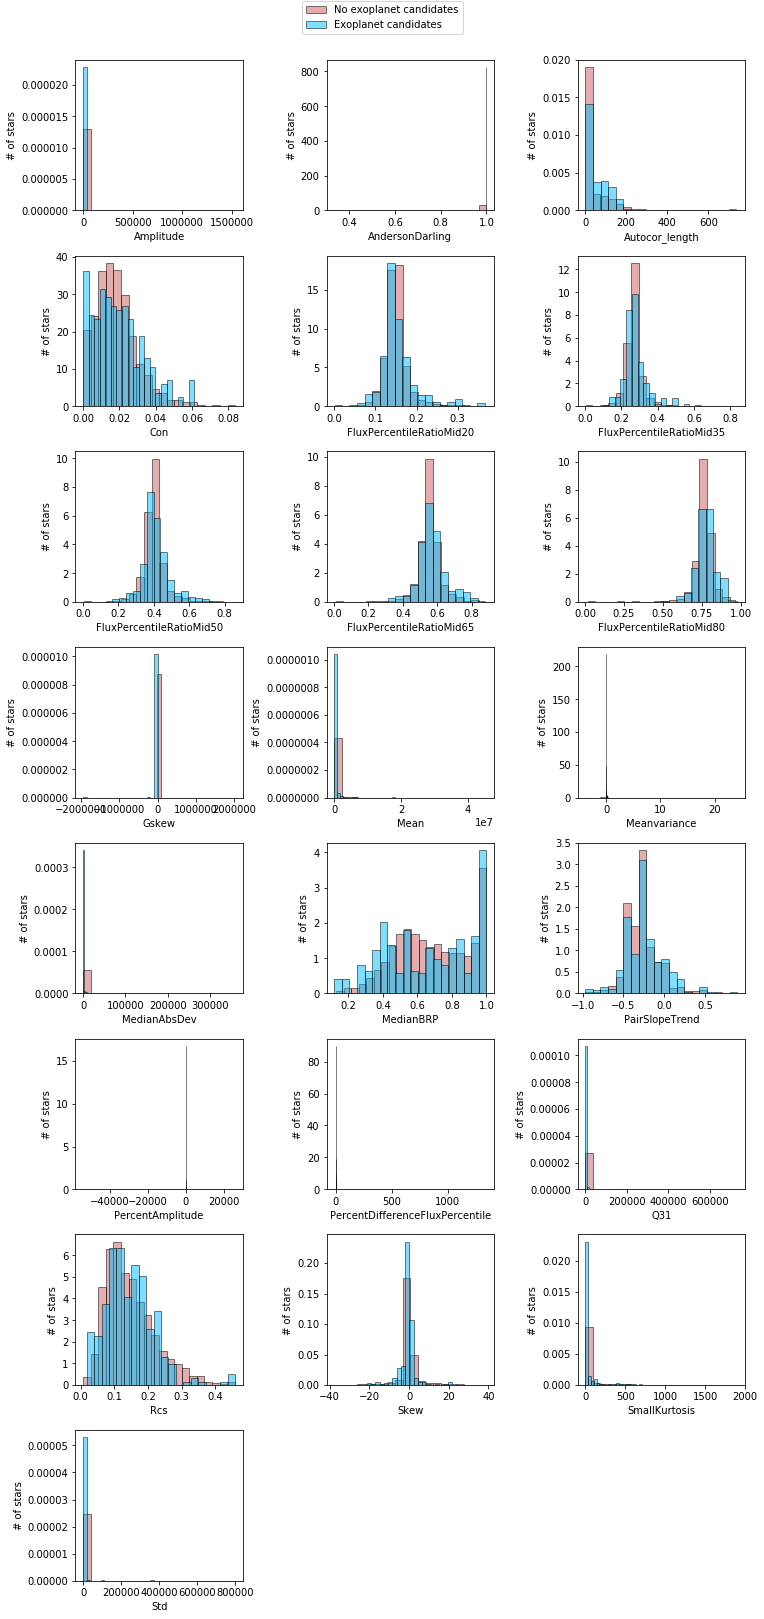

In [18]:
n_exoplanet = labels.label.sum()

fig = plt.figure(figsize=(12,25))
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.3)

for i,feature in enumerate(flux_med_features.columns.values):
    ax = fig.add_subplot(8,3,i+1)
    
    pos_feature = flux_med_features[feature].iloc[:n_exoplanet].values
    neg_feature = flux_med_features[feature].iloc[n_exoplanet:].values
    
    ax.hist(neg_feature,alpha=0.5,bins=20,color='indianred',edgecolor='black',density=True,label='No exoplanet candidates')
    ax.hist(pos_feature,alpha=0.5,bins=20,color='deepskyblue',edgecolor='black',density=True,label='Exoplanet candidates')

    ax.set_xlabel(feature)
    ax.set_ylabel('# of stars')   

fig.legend(labels=['No exoplanet candidates','Exoplanet candidates'],loc="upper center",borderaxespad=0.1)
plt.subplots_adjust(top=0.97)
plt.show()

In [19]:
chosen_features = ['Autocor_length','Con','Gskew','SmallKurtosis','Std']
flux_med_features_chosen = flux_med_features[chosen_features]

#### PCA

In [20]:
from sklearn.decomposition import PCA

# Apply PCA to flux_features data
pca = PCA(n_components=4).fit(flux_sg_features)

for n_components in range(1,5):
    print('Cumulative variance explained by {} components: {:.4f}'.format(n_components,sum(pca.explained_variance_ratio_[range(0,n_components)])))

Cumulative variance explained by 1 components: 0.9969
Cumulative variance explained by 2 components: 0.9992
Cumulative variance explained by 3 components: 0.9999
Cumulative variance explained by 4 components: 1.0000


In [24]:
# Dimension indexing
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = list(flux_med_features_chosen.keys()))
components.index = dimensions

In [27]:
# Display weights of most significant features making up a chosen principal component
i_component = 0
principal_component = components.iloc[i_component]

print('Principal component {} weights'.format(i_component+1))
principal_component.reindex(principal_component.abs().sort_values(ascending=False).index).head()

Principal component 1 weights


Gskew             0.9855
Std               0.1695
Autocor_length    0.0001
SmallKurtosis    -0.0000
Con               0.0000
Name: Dimension 1, dtype: float64

In [21]:
# PCA on flux_features
pca = PCA(n_components=4).fit(flux_features)
pca_features = pca.transform(flux_features)

# PCA on flux_med_features
pca = PCA(n_components=4).fit(flux_med_features)
pca_med_features = pca.transform(flux_med_features)

# PCA on flux_sg_features
pca = PCA(n_components=4).fit(flux_sg_features)
pca_sg_features = pca.transform(flux_sg_features)

# PCA on flux_med_features_chosen
pca = PCA(n_components=2).fit(flux_med_features_chosen)
pca_med_features_chosen = pca.transform(flux_med_features_chosen)

#### Normalisation/Standardisation

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
flux_features_norm = scaler.fit_transform(flux_features.values)

flux_med_features_norm = scaler.fit_transform(flux_med_features.values)
pca_med_features_norm = scaler.fit_transform(pca_med_features)
flux_med_features_chosen_norm = scaler.fit_transform(flux_med_features_chosen.values)

flux_med_up_features_norm = scaler.fit_transform(flux_med_up_features.values)

flux_sg_features_norm = scaler.fit_transform(flux_sg_features.values)
pca_sg_features_norm = scaler.fit_transform(pca_sg_features)

flux_norm_features_norm = scaler.fit_transform(flux_norm_features.values)
flux_norm_med_features_norm = scaler.fit_transform(flux_norm_med_features.values)

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
flux_features_std = scaler.fit_transform(flux_features.values)
flux_med_features_std = scaler.fit_transform(flux_med_features.values)
flux_sg_features_std = scaler.fit_transform(flux_sg_features.values)
flux_norm_features_std = scaler.fit_transform(flux_norm_features.values)
flux_norm_med_features_std = scaler.fit_transform(flux_norm_med_features.values)

---

### Classification using extracted features

In [13]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

##### Spot-checking various algorithms

In [14]:
# Algorithm spot-check
from sklearn.metrics import fbeta_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def predictor(classifier, X, y, test_size=0.25, beta=2, oversample=0):
    
    # split dataset into training and test subsets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # resample training dataset using SMOTE
    if oversample>0:
        sm = SMOTE(sampling_strategy=oversample,random_state=42)
        x_train, y_train = sm.fit_resample(x_train, y_train)
        
    # fit the model using the training data
    model = classifier.fit(x_train, y_train)
    
    # make prediction on first 500 samples of training set
    y_pred_train = model.predict(x_train[:500])
    
    # make prediction on test set
    y_pred_test = model.predict(x_test)
    
    # calculate f-score, recall and accuracy on training and test set
    score_train = fbeta_score(y_train[:500], y_pred_train, beta)
    score_test = fbeta_score(y_test, y_pred_test, beta)
    
    recall_train = recall_score(y_train[:500],y_pred_train)
    recall_test = recall_score(y_test,y_pred_test)
    
    accuracy_train = accuracy_score(y_train[:500],y_pred_train)
    accuracy_test = accuracy_score(y_test,y_pred_test)
    
    fscore = [score_train,score_test]
    recall = [recall_train,recall_test]
    accuracy = [accuracy_train,accuracy_test]
        
    return fscore, recall, accuracy, y_pred_test, y_pred_train

In [26]:
# Dictionary containing all possible datasets to be tested for the classification
x_options = dict()

x_options['flux_features'] = flux_features.values
x_options['flux_features_norm'] = flux_features_norm
x_options['flux_med_features'] = flux_med_features.values
x_options['flux_med_features_norm'] = flux_med_features_norm
x_options['flux_med_features_std'] = flux_med_features_std
x_options['chosen flux_med_features'] = flux_med_features_chosen.values
x_options['chosen flux_med_features_norm'] = flux_med_features_chosen_norm
x_options['flux_sg_features'] = flux_sg_features.values
x_options['flux_sg_features_norm'] = flux_sg_features_norm
x_options['flux_sg_features_std'] = flux_sg_features_std
x_options['flux_norm_features'] = flux_norm_features.values
x_options['flux_norm_features_norm'] = flux_norm_features_norm
x_options['flux_norm_features_std'] = flux_norm_features_std
x_options['flux_norm_med_features'] = flux_norm_med_features.values
x_options['flux_norm_med_features_norm'] = flux_norm_med_features_norm
x_options['flux_norm_med_features_std'] = flux_norm_med_features_std
x_options['flux_med_up_features'] = flux_med_up_features.values
x_options['flux_med_up_features_norm'] = flux_med_up_features_norm

x_options['pca_features'] = pca_features
x_options['pca_med_features'] = pca_med_features
x_options['chosen pca_med_features'] = pca_med_features_chosen
x_options['pca_med_features_norm'] = pca_med_features_norm
x_options['pca_sg_features'] = pca_sg_features_norm

In [27]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

# Dictionary containing all classification models to be tested
models = dict()

models['Logistic'] = LogisticRegression(class_weight='balanced', random_state=42)
models['SGD'] = SGDClassifier(class_weight='balanced', random_state=42)

models['Decision Tree'] = DecisionTreeClassifier(class_weight='balanced', random_state=42)

models['Linear SVM'] = SVC(kernel='linear', class_weight='balanced', max_iter=10000, random_state=42)
models['Cubic SVM'] = SVC(kernel='poly', class_weight='balanced', max_iter=10000, random_state=42)
for c in np.arange(0.1, 1.1, 0.1):
    models['RBF SVM (C = '+str(c)+')'] = SVC(C=c, class_weight='balanced', max_iter=10000, random_state=42)

models['Naive Bayes'] = GaussianNB()

models['AdaBoost'] = AdaBoostClassifier(n_estimators=50 ,random_state=42)
models['Gradient Boosting'] = GradientBoostingClassifier(n_estimators=50 ,random_state=42)
models['Bagging'] = BaggingClassifier(n_estimators=50 ,random_state=42)
models['Random Forest'] = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)

In [27]:
x = x_options['flux_med_features_norm']
y = labels.label.get_values()

scores = []
recalls = []
accuracies = []

for model in models:
    
    score, recall, accuracy, y_pred_test, y_pred_train = predictor(models[model], x, y, oversample=1)
    
    scores.append(score[1])
    recalls.append(recall[1])
    accuracies.append(recall[1])
    
    print(model)
    print('\nTraining set')
    print('F-score = {:.2f}%'.format(score[0]*100))
    print('Recall = {:.2f}%'.format(recall[0]*100))
    print('Accuracy = {:.2f}%'.format(accuracy[0]*100))
    print('\nTest set')
    print('F-score = {:.2f}%'.format(score[1]*100))
    print('Recall = {:.2f}%'.format(recall[1]*100))
    print('Accuracy = {:.2f}%'.format(accuracy[1]*100))
    print('----------------------------------------------')

Logistic

Training set
F-score = 33.06%
Recall = 66.67%
Accuracy = 58.60%

Test set
F-score = 34.61%
Recall = 65.88%
Accuracy = 55.80%
----------------------------------------------
SGD

Training set
F-score = 9.20%
Recall = 8.33%
Accuracy = 90.20%

Test set
F-score = 2.71%
Recall = 2.35%
Accuracy = 89.00%
----------------------------------------------
Decision Tree

Training set
F-score = 100.00%
Recall = 100.00%
Accuracy = 100.00%

Test set
F-score = 25.54%
Recall = 30.59%
Accuracy = 79.80%
----------------------------------------------
Linear SVM

Training set
F-score = 34.48%
Recall = 66.67%
Accuracy = 61.60%

Test set
F-score = 32.91%
Recall = 61.18%
Accuracy = 56.90%
----------------------------------------------
Cubic SVM

Training set
F-score = 9.20%
Recall = 8.33%
Accuracy = 90.20%

Test set
F-score = 4.12%
Recall = 3.53%
Accuracy = 89.70%
----------------------------------------------
RBF SVM (C = 0.1)

Training set
F-score = 28.63%
Recall = 36.11%
Accuracy = 81.40%

Test set

In [28]:
print('Max F-score using {}: {:.2f}%'.format(list(models)[np.argmax(scores)],max(scores)*100))

Max F-score using Gradient Boosting: 39.47%


In [27]:
y = labels.label.get_values()

for i_x,x in x_options.items():

    scores = []
    recalls = []
    accuracies = []
    overs = []
    
    for i_model,model in models.items():
    
        best_score = 0
        best_recall = 0
        best_accuracy = 0
        best_over = 0
    
        for over in np.arange(0,1.1,0.1):
            score, recall, accuracy, y_pred_test, y_pred_train = predictor(model, x, y, oversample=over)
        
            if score[1]>best_score:
                best_score=score[1]
                best_recall=recall[1]
                best_accuracy=accuracy[1]
                best_over=over
        
        if not scores or best_score>np.max(scores):
            best_model = i_model
            
        scores.append(best_score)
        recalls.append(best_recall)
        accuracies.append(best_accuracy)
        overs.append(best_over)
    
    print('{} - Best Model: {}, with oversampling ratio of {}'.format(i_x,best_model,overs[np.argmax(scores)]))
    print('F-score: {:.2f}%'.format(max(scores)*100))
    print('Recall: {:.2f}%'.format(recalls[np.argmax(scores)]*100))
    print('Accuracy: {:.2f}%'.format(accuracies[np.argmax(scores)]*100))          
    print('----------------------------------------------')

flux_features - Best Model: Gradient Boosting_10, with oversampling ratio of 0.8
F-score: 37.22%
Recall: 54.12%
Accuracy: 72.90%
----------------------------------------------
flux_features_norm - Best Model: Gradient Boosting_10, with oversampling ratio of 0.9
F-score: 39.88%
Recall: 61.18%
Accuracy: 70.70%
----------------------------------------------
flux_med_features - Best Model: Gradient Boosting_10, with oversampling ratio of 0.8
F-score: 39.67%
Recall: 56.47%
Accuracy: 74.60%
----------------------------------------------
flux_med_features_norm - Best Model: Gradient Boosting_10, with oversampling ratio of 1.0
F-score: 43.72%
Recall: 75.29%
Accuracy: 65.10%
----------------------------------------------
flux_med_features_std - Best Model: Gradient Boosting_10, with oversampling ratio of 1.0
F-score: 41.18%
Recall: 75.29%
Accuracy: 60.60%
----------------------------------------------
chosen flux_med_features - Best Model: Gradient Boosting_50, with oversampling ratio of 0.9
F-

##### GridSearch

In [29]:
x = x_options['flux_med_features_norm']

In [30]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score
from imblearn.pipeline import Pipeline

# Initialize imblearn pipeline with chosen unoptimized classifier
# note: n_estimators = 20 chosen using grid search with default/untuned Decision Tree parameters. This is then fixed in order to tune the decision tree hyparameters.
model = Pipeline([('oversample', SMOTE(sampling_strategy=1,random_state=42)),('clf', GradientBoostingClassifier(random_state=42))])


# Parameters to be tuned
params_1 = {'clf__n_estimators':range(10,101,10)}
params_2 = {'clf__n_estimators':[20],'clf__max_depth':range(3,16,2), 'clf__min_samples_split':range(2,100,5)}
params_3= {'clf__n_estimators':[20],'clf__min_samples_leaf':range(1,22,2)}
params_4 = {'clf__n_estimators':[20],'clf__max_features':range(3,int(x.shape[1]),2)}
params_5 = {'clf__learning_rate':[0.05,1,1.5,2],'clf__n_estimators':range(10,101,10)}

# Make an fbeta_score scorer
scorer = make_scorer(fbeta_score,beta=2)

# Split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid = GridSearchCV(estimator=model, param_grid=params_1, cv=5, scoring=scorer, n_jobs=-1)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid.fit(x_train,y_train)

# Get the estimator
best_model = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model
predictions = (model.fit(x_train, y_train)).predict(x_test)
best_predictions = best_model.predict(x_test)

# Report the before-and-afterscores
print('Unoptimized model\n------------')
print('F-score on test data: {:.2f}%'.format(fbeta_score(y_test, predictions, beta = 2)*100))
print('Recall on test data: {:.2f}%'.format(recall_score(y_test, predictions)*100))
print('Accuracy score on test data: {:.2f}%'.format(accuracy_score(y_test, predictions)*100))

print('\nOptimized Model\n------------')
print('Final F-score on the test data: {:.2f}%'.format(fbeta_score(y_test, best_predictions, beta = 2)*100))
print('Final recall on the test data: {:.2f}%'.format(recall_score(y_test, best_predictions)*100))
print('Final accuracy score on the test data: {:.2f}%'.format(accuracy_score(y_test, best_predictions)*100))

print('\nOptimal parameters:')
print(grid_fit.best_params_)

Unoptimized model
------------
F-score on test data: 32.19%
Recall on test data: 37.65%
Accuracy score on test data: 82.20%

Optimized Model
------------
Final F-score on the test data: 44.03%
Final recall on the test data: 69.41%
Final accuracy score on the test data: 70.30%

Optimal parameters:
{'clf__n_estimators': 20}


---

### Classification using flux time-series and neural networks

In [15]:
# Dictionary containing all possible datasets to be tested for classification
x_options = dict()
x_options['flux_raw'] = flux.values
x_options['flux_norm'] = flux_norm.values
x_options['flux_std'] = flux_std.values
x_options['flux_med'] = flux_med
x_options['flux_norm_med'] = flux_norm_med
x_options['flux_med_up'] = flux_med_up
x_options['flux_norm_med_up'] = flux_norm_med_up
x_options['flux_sg'] = flux_sg
x_options['flux_norm_sg'] = flux_norm_sg

In [16]:
from keras.utils import np_utils

x = x_options['flux_raw']
x = np.reshape(x,(x.shape[0], x.shape[1], 1))

y = labels.label.get_values()
y = np_utils.to_categorical(y,2)

# Split dataset into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

Using TensorFlow backend.


In [17]:
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv1D(16,11,padding='valid',input_shape=x_train.shape[1:],activation='relu'))
model.add(MaxPooling1D(pool_size=2,padding='valid'))
model.add(Dropout(0.25))
model.add(Conv1D(32,11,padding='valid',activation='relu'))
model.add(MaxPooling1D(pool_size=2,padding='valid'))
model.add(Dropout(0.25))

#model.add(Conv1D(64,5,padding='valid',activation='relu'))
#model.add(MaxPooling1D(pool_size=2,padding='valid'))
#model.add(Dropout(0.25))

#model.add(Conv1D(128,5,padding='valid',activation='relu'))
#model.add(MaxPooling1D(pool_size=2,padding='valid'))
#model.add(Dropout(0.25))

#model.add(GlobalAveragePooling1D())

model.add(Flatten())
model.add(Dense(2,activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3152, 16)          192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1576, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1576, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1566, 32)          5664      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 783, 32)           0         
_________________________________________________________________
dropout_2 (Dropout)  

In [18]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',np.unique(np.argmax(y_train,axis=1)),np.argmax(y_train,axis=1))
class_weights = dict(enumerate(class_weights))

In [20]:
from keras.callbacks import ModelCheckpoint  

epochs = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.cnn.hdf5', 
                               verbose=1, save_best_only=True)

hist = model.fit(x_train, y_train, batch_size=32, epochs=epochs, validation_split=0.2, class_weight=class_weights, callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 2400 samples, validate on 600 samples
Epoch 1/50
2400/2400 [==============================] - 7s 3ms/step - loss: 8.0831 - acc: 0.9313 - val_loss: 7.8499 - val_acc: 0.9367

Epoch 00001: val_loss improved from inf to 7.84986, saving model to saved_models/weights.best.cnn.hdf5
Epoch 2/50
2400/2400 [==============================] - 7s 3ms/step - loss: 8.0564 - acc: 0.9350 - val_loss: 7.8499 - val_acc: 0.9367

Epoch 00002: val_loss did not improve from 7.84986
Epoch 3/50
2400/2400 [==============================] - 7s 3ms/step - loss: 8.0564 - acc: 0.9350 - val_loss: 7.8499 - val_acc: 0.9367

Epoch 00003: val_loss did not improve from 7.84986
Epoch 4/50
2400/2400 [==============================] - 7s 3ms/step - loss: 8.0564 - acc: 0.9350 - val_loss: 7.8499 - val_acc: 0.9367

Epoch 00004: val_loss did not improve from 7.84986
Epoch 5/50
2400/2400 [==============================] - 7s 3ms/step - loss: 8.0564 - acc: 0.9350 - val_loss: 

2400/2400 [==============================] - 7s 3ms/step - loss: 8.0564 - acc: 0.9350 - val_loss: 7.8499 - val_acc: 0.9367

Epoch 00043: val_loss did not improve from 7.84986
Epoch 44/50
2400/2400 [==============================] - 7s 3ms/step - loss: 8.0564 - acc: 0.9350 - val_loss: 7.8499 - val_acc: 0.9367

Epoch 00044: val_loss did not improve from 7.84986
Epoch 45/50
2400/2400 [==============================] - 7s 3ms/step - loss: 8.0564 - acc: 0.9350 - val_loss: 7.8499 - val_acc: 0.9367

Epoch 00045: val_loss did not improve from 7.84986
Epoch 46/50
2400/2400 [==============================] - 7s 3ms/step - loss: 8.0564 - acc: 0.9350 - val_loss: 7.8499 - val_acc: 0.9367

Epoch 00046: val_loss did not improve from 7.84986
Epoch 47/50
2400/2400 [==============================] - 7s 3ms/step - loss: 8.0564 - acc: 0.9350 - val_loss: 7.8499 - val_acc: 0.9367

Epoch 00047: val_loss did not improve from 7.84986
Epoch 48/50
2400/2400 [==============================] - 7s 3ms/step - loss: 

In [21]:
model.load_weights('saved_models/weights.best.cnn.hdf5')

In [26]:
predictions = [np.argmax(model.predict(x_test),axis=1)]